# Testing: Pixel Based Heatwaves

## About: 
This notebook is a proof of concept notebook for testing efficient workflows for estimating and processing marine heatwave tracking in space/time at a ixel level. The testing area will be the Gulf of Maine, and the methods will follow Jacox et al. 2020.

### Testing Details:
 * Baseline reference period: 1982-2022
 * Linear trend years: 1982-2022
 * Heatwave threshold: 90%

### Process:
 * Make an "expected" anomaly xr.Dataset that can be quickly checked against
    * This is the prediction from linear trend
 * Update linear trends annually as new data comes in
 * Make functions that can match anomalies against these expectations
    * Pair on date, find difference from the prediction, and flag whether it falls within or outside extreme event threshold

In [1]:
# Libraries
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
import oisstools as ot
 
# Set Notebook Options:  -----------------------------------
box_root = ot.set_workspace("local")

# Set Baseline Reference Period
reference_period = "1982-2020"

# Set Start and End Year to Load
start_year = 1982
end_year = 2022

# Confirm and Report what options are selected -----------
print(f"Working via directory at: {box_root}")
print(f"Calculating extreme events over {reference_period} reference period & using linear-detrending for years: {start_year}-{end_year}")


Working via directory at: /Users/akemberling/Library/CloudStorage/Box-Box/
Calculating extreme events over 1982-2020 reference period & using linear-detrending for years: 1982-2022


# Load OISST

We need to load observation data for the whole time period we are de-trending over, and then we can crop the lat/lo dimensions to speed things up.

 * Lat min = 40.375   
 * Lon min = -70.875   
 * Lat max = 45.125
 * Lon max = -65.375


In [2]:
# Load 40+ Years of sst
sst_obs = ot.load_box_oisst(box_root, 
                            start_year, 
                            end_year, 
                            anomalies = False, 
                            do_parallel = True)

## Crop to Gulf of Maine

Zoom into the gulf of maine to get a manageable sized area to work with:
 * Latitude: 40.375 to 45.125
 * Longitude: 

In [3]:
# # Set Gom Dimensions
# gom_dims = {
#     "lat_min": 40.375,
#     "lon_min": 360 - 70.875,
#     "lat_max": 45.125,
#     "lon_max": 360 - 65.375}

# Set Bigger Gom Dimensions
gom_dims = {
    "lat_min": 39,
    "lon_min": 360 - 74.5,
    "lat_max": 45.5,
    "lon_max": 360 - 60.5}

# Filter coordinates
gom_sst = sst_obs.sel(
    lon = slice(gom_dims["lon_min"], gom_dims["lon_max"]), 
    lat = slice(gom_dims["lat_min"], gom_dims["lat_max"]))

# Load it for speed
gom_sst.load()
sst_obs.close()

### Map a Day of Temperatures

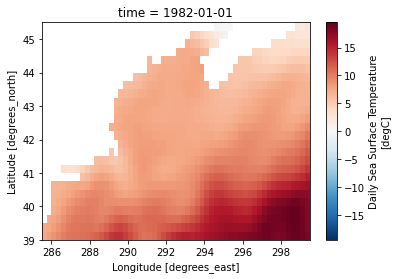

In [4]:
# Map Check
gom_sst.sst.isel(time = 0).plot()

# Processing Day of Year Trends

Set a coordinate that tracks the day of the year. Multiple ways to approach leap years:

In [5]:

###### Leap-year Option 1:   #####
# Day of year is just 1...n no matter if leap  year or no
gom_sst = gom_sst.assign_coords({"doy" : gom_sst.time.dt.dayofyear}) 

# ###### Leap-year Option 2: #####

# # Preserve "Day within Month" around leap-years
# # Add day of year dimension
# gom_sst = ot.add_mod(grid_obj= gom_sst, time_dim="time")


# Pixel-by-pixel Trends in SST

The following code chunks were used to test/develop the group_linear_trend() function. The goal of the function is to fit annual trends for each day of the year. It returns the original values, the predicted values from the linear trend, and the difference in the two (residuals).

## Define the De-Trending Function

In [6]:

# define a function to compute a linear trend of a timeseries
# Expected input is some sort of group within the scope of a year. Example: months, or day of year
# Trend is fit using "time" dimension so it needs to be passed some subset of unique time elements within a year
# example: all Jan1 indices
def group_linear_trend(x, start_yr, end_yr, detrend_var = "sst"):

    # Limit the years
    year_subset = x.sel(time = slice(f"{start_yr}-01-01", f"{end_yr}-12-31"))

    # Fit annual trend for the group
    # https://stackoverflow.com/questions/66594056/linear-regression-on-each-grid-cell-across-time-dim

    # Polyfit coefficients
    coeffs = getattr(year_subset, detrend_var).polyfit(dim = "time", deg = 1)

    # polyval predictions
    pred = xr.polyval(coord = year_subset.time, coeffs = coeffs)

    # Unexplained variation (residuals): 
    unexplained = getattr(year_subset, detrend_var) - pred

    # renaming the outputs, once residuals are calculated:
    pred = pred.rename_vars({"polyfit_coefficients" : "trend_preds"})
    unexplained = unexplained.rename_vars({"polyfit_coefficients" : "trend_residuals"})

    # Join them up: original, trend predictions, residuals
    detrend_ds = xr.merge([year_subset, pred, unexplained])
    
    # Return the results
    return detrend_ds
    


# Testing: Linear Trend using apply()

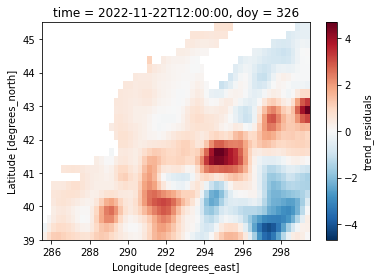

In [7]:
# Try using it in conjunction with groupby and apply:
gom_detrended = gom_sst.groupby("doy").apply(group_linear_trend, start_yr = 1982, end_yr = 2022, detrend_var = "sst")

# map a day
gom_detrended.isel(time = -40).trend_residuals.plot()

---

# Next Steps 

1. Set Climate Reference points
2. Smooth trends across adjacent day of  year, so leap years blend in better 
3. Set De-Trended Thresholds
4. Flag Extreme Events 
5. Track event durations through time  



# 1. Get Climatological Reference Points:

In [8]:
# Climatology Reference Period Thresholds

def calc_ref_thresholds(x, start_year, end_year, mhw_pct = 0.9, clim_idx = "doy"):
    """
    x: xr.dataset with sst data indexed by time and with some daily climatology index to use like day of year (doy)
    start_year: starting year to use for reference period for thresholds and averages
    end_year: ending year to use for reference period for thresholds and averages
    mhw_pct: Percentile to use to set MHW threshold using quantile
    clim_idx: string indicating the index to group over for daily/monthly climatological references
    """
    
    # Pull the reference period years - Limit to the 30 years of interest
    ref_period = x.sel(time = slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    # Group on the modified ordinal day then get the means for climatological average
    x_clim = ref_period.sst.groupby(clim_idx).mean('time', keep_attrs = True).to_dataset().rename_vars({"sst" : "sst_clim"})

    # Set MHW threshold
    
    # Get Quantile thresholds by modified ordinal day
    hw_threshold = ref_period.groupby(clim_idx).quantile(mhw_pct, dim='time', keep_attrs=True, skipna=True).rename_vars({"sst" : "hw_thresh"})

    # # Cold Spells
    mcs_pct = 1 - mhw_pct
    cs_threshold = ref_period.groupby(clim_idx).quantile(mcs_pct, dim='time', keep_attrs=True, skipna=True).rename_vars({"sst" : "cs_thresh"})

    # Merge them to Get a complete building block for MHW
    ref_thresholds = xr.merge([x_clim, hw_threshold.drop("quantile"), cs_threshold.drop("quantile")])

    # Return the xarray.dataset
    return ref_thresholds





/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


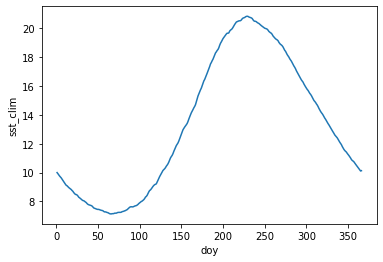

In [9]:
# Run Calculations
ref_thresholds = calc_ref_thresholds(
    x = gom_sst, 
    start_year = start_year, 
    end_year = end_year, 
    mhw_pct = 0.9, 
    clim_idx = "doy")

# For comparing against rolling average:
ref_thresholds.sst_clim.mean(("lon", "lat")).plot()

# 2. Smooth the Daily Climatology with Rolling Average

The code for the heatwaveR package using a moving window to smooth out the climatological mean and the marine heatwave/coldspell thresholds. The size of that window is 5 days both before and after the day of the year. This should be implemented for each pixel to smooth out the daily trend in sst/thresholds.


### Rolling Average with Annual Cycle Preserved

The following code adds the last days of the year as a lead in to the seasonal cycle and the first days of the year as a fade out. This gives the rolling window data to use for connecting the ends of the seasonal cycle.

In [10]:
# Apply a rolling average to climat reference thresholds
def smooth_clim(x, clim_idx = "doy", window_len = 6, center = True, min_periods = 1):

    # Length of the array to append to
    array_len = x[clim_idx].shape[0]

    # Days to place in the front
    head_buffer = x.sel(doy = slice(array_len - window_len, array_len))
    head_buffer = head_buffer.assign_coords({"doy" : head_buffer.coords[clim_idx] - array_len})

    # # These days will append to the end:
    tail_buffer = x.sel(doy = slice(0, window_len))
    tail_buffer = tail_buffer.assign_coords({"doy" : tail_buffer.coords[clim_idx] + array_len})

    # Combine & Check them
    roll_rdy = xr.concat([head_buffer, x,  tail_buffer], dim = "doy")

    # Perform rolling average
    x_rolled = roll_rdy.rolling(doy = window_len, center = center, min_periods = min_periods).mean()

    # take off the header
    x_rolled = x_rolled.sel(doy = slice(1, 366))

    return x_rolled

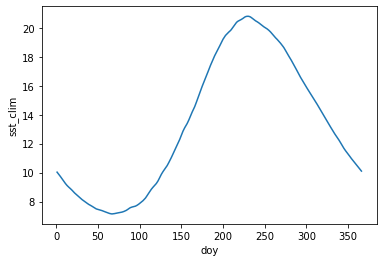

In [11]:
# plot to show results
ref_rolled = smooth_clim(x = ref_thresholds, clim_idx = "doy", window_len = 6)
ref_rolled.sst_clim.mean(("lon", "lat")).plot()

# Part 3: Comparing De-Trended Temperatures to a Baseline HW Threhold

Process:
 1. Merge the reference period average temperatures and thresholds into the data that has original and detrended sst
 2. Adding the trend residuals to the reference period climatology should give you how much hotter/colder it was than the reference mean, without the long-term trend
 3. These can then be flagged against the thresholds from the reference period for marine heatwaves
 4. Then all that is left is the nightmare of tracking events in time with 5 days initiation and minimum of 3 days to break events...
 

These values (difference from trend) can be added to the climatology and referenced against the climatologies HW thresholds. Or we need to get pixel by pixel thresholds that move through time, these could be quantiles from reference period + trend, or we could de-trend anomalies

In [12]:
# This code all works but isn't necessary, anomalies from reference period not needed for jacox methodology

# # Put the original sst, the detrended data, the climatology details together in one dataset:
# gom_all = xr.merge([gom_detrended, ref_rolled])

# # Function to match day of year when running anomalies
# def calc_clim_anom(daily_sst, daily_clims, clim_idx = "doy", obs_var = "sst", clim_var = "sst_clim"):
#     """
#     Return Anomaly for Matching Modified Ordinal Day (day of year 1-366 adjusted for leap-years)
    
#     daily_sst : xarray data array of sea surface temperatures containing "MOD" coordinate to pair with daily_clims
#     daily_clim : xarray data array of sea surface temperature climatologic means.
#     clim_idx : string of the coordinate to match on
    
#     """

#     # Grab the climatology slice that matches the date
#     clim_date_match = daily_clims.sel(doy = daily_sst[clim_idx])
    
#     # Subtract the observations with that climatological avg
#     daily_sst["ref_avg"] = getattr(clim_date_match, clim_var)
#     daily_sst["ref_anom"] = getattr(daily_sst, obs_var) - getattr(clim_date_match, clim_var)
#     return daily_sst


# # Do anomalies this way to avoid the association with doy: 
# gom_all = gom_detrended.groupby("time").map(
#     calc_clim_anom,
#     daily_clims = ref_rolled
# )
# gom_all

# 4. Get Extreme Events from De-Trended SST
If we then add these detrended values to the climatological mean we can get a de-trended timeseries:


In [13]:
# Grab a year to speed up testing
test_year = gom_detrended.sel(time = gom_detrended.time.dt.year == 2020)

## Benchmarking De-Trended Values Against Heatwave Thresholds

This part is a little confusing because the threhsolds are static and do not progress with the long-term trends. To compare against them we instead use the de-trended values or their residuals to benchmark with:

In [14]:
# Define a function to: 
# 1. match trend residuals to the climatological mean & thresholds for each day
# 2. Flag when those new values exceed thresholds for extreme events

def detect_jacox_events(detrend_ds, threshold_ds, detrend_var = "trend_residuals", clim_idx = "doy", clim_avg_var = "sst_clim", thresh_high = "hw_thresh", thresh_low = "cs_thresh"):
    """
    detrend_ds: xr.dataset containing de-trended temperatures or some other variable
    threshold_ds: xr.dataset containing the climatological mean and extreme event thresholds for some reference period
    """

    # pull the climatology slice that matches the day of the year
    threshold_match = threshold_ds.sel(doy = detrend_ds[clim_idx])

    # # Add the overall (reference period) average (not necessary)
    # detrend_ds["ref_avg"] = getattr(threshold_match, clim_avg_var)
    
    # Add trend residuals to the climatology avg
    detrend_ds["detrend_var"] = getattr(detrend_ds, detrend_var) + getattr(threshold_match, clim_avg_var)

    # # Compare if they are over the threshold or no, event flagging
    detrend_ds["is_hw"] = detrend_ds.detrend_var > getattr(threshold_match, thresh_high)
    detrend_ds["is_cs"] = detrend_ds.detrend_var < getattr(threshold_match, thresh_low)

    return detrend_ds.drop("doy")


## Running All Dates

In [15]:
# Plot the detrended sst + climatological mean
jtest = gom_detrended.groupby("time").map(
    detect_jacox_events, 
    threshold_ds=ref_rolled, 
    detrend_var = "trend_residuals", 
    clim_avg_var = "sst_clim",
    thresh_high = "hw_thresh", 
    thresh_low = "cs_thresh")
jtest

<xarray.Dataset>
Dimensions:          (time: 14975, lat: 26, lon: 56)
Coordinates:
  * time             (time) datetime64[ns] 1982-01-01 ... 2022-12-31T12:00:00
  * lat              (lat) float32 39.12 39.38 39.62 39.88 ... 44.88 45.12 45.38
  * lon              (lon) float32 285.6 285.9 286.1 286.4 ... 298.9 299.1 299.4
    doy              (time) int64 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
Data variables:
    sst              (time, lat, lon) float32 7.53 8.1 8.73 ... 4.93 4.87 5.08
    trend_preds      (time, lat, lon) float64 7.7 8.275 8.854 ... 4.068 4.054
    trend_residuals  (time, lat, lon) float64 -0.1696 -0.1751 ... 0.8024 1.026
    detrend_var      (time, lat, lon) float64 7.549 8.169 8.853 ... 4.072 4.303
    is_hw            (time, lat, lon) bool False False False ... False False
    is_cs            (time, lat, lon) bool False False False ... False False
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

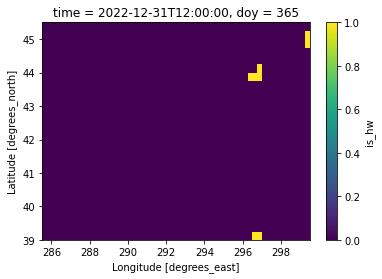

In [16]:
# Plot what a day of hw events looks like
jtest.isel(time = -1).is_hw.plot()

In [17]:
# Save it out to use offline and in R:
jtest.to_netcdf(f"{box_root}/RES_Data/OISST/oisst_mainstays/jacox_events/nw_atlantic_82to22.nc")

---

# Data Checks:

## Comparison: De-Trending Anomalies

Do we get different results de-trending anomalies from the reference period than we get de-trending the temperatures? **NO**

Residuals from d-trending both temperature and sst anomalies are equal. This makes sense because they (sst & anoms) are 1:1 correlated with one another. This means we only need to de-trend one and can do it in the beginning with temperature.

In [ ]:
# Code Works, just not needed:

# # Pull a subset of the variables to prevent conflicts merging later:
# gom_anoms = gom_all[["ref_anom"]]
# gom_anoms["doy"] = gom_anoms.time.dt.dayofyear

# # Use the detrending function on the reference period anomalies:
# anom_detrend = gom_anoms.groupby("doy").apply(group_linear_trend, start_yr = 1982, end_yr = 2022, detrend_var = "ref_anom")
# anom_detrend